### Example 1 (FBP and Fourier)

#### This example shows how to use methods from the HTTomolibgpy library to do the following:
* normalise the data 
* calculate the centre of rotation 
* reconstruct using the FBP and Fourier algorithms

The shape of the data is (180, 128, 160) as (projections, detector Y, detector X)
Normalising the data


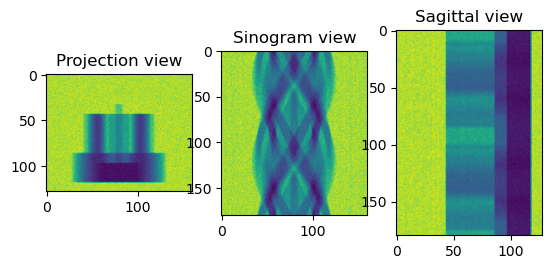

In [4]:
import os
import numpy as np
import cupy as cp
import httomolibgpu
import matplotlib.pyplot as plt
from httomolibgpu.prep.normalize import normalize

# Load the projection data
path_lib = os.path.dirname(httomolibgpu.__file__)
in_file = os.path.abspath(os.path.join(path_lib, '..', "tests/test_data/",'tomo_standard.npz'))
datafile = np.load(in_file)
host_data = datafile['data']
host_flats = datafile['flats']
host_darks = datafile['darks']

print("The shape of the data is {} as (projections, detector Y, detector X)".format(np.shape(host_data)))

print("Normalising the data")
data = cp.asarray(host_data)
flats = cp.asarray(host_flats)
darks = cp.asarray(host_darks)
data_normalised = normalize(data, flats, darks, cutoff = 10, minus_log = False)

sliceSel = 64
data_normalised_np = data_normalised.get()

plt.figure()
plt.subplot(131)
plt.imshow(data_normalised_np[sliceSel, :, :])
plt.title("Projection view")

plt.subplot(132)
plt.imshow(data_normalised_np[:, sliceSel, :])
plt.title("Sinogram view")

plt.subplot(133)
plt.imshow(data_normalised_np[:, :, sliceSel])
plt.title("Sagittal view")
plt.show()

In [5]:
from httomolibgpu.recon.rotation import find_center_vo

print ("Finding the Center of Rotation for the reconstruction")
cor = find_center_vo(data_normalised, ind=64)
print("The found Center of Rotation is {}".format(cor))

Finding the Center of Rotation for the reconstruction
The found Center of Rotation is 79.5


Applying Paganin filter


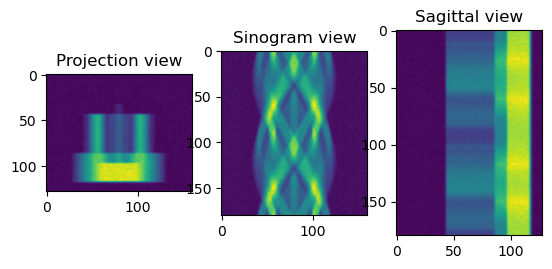

In [6]:
from httomolibgpu.prep.phase import paganin_filter_tomopy

print ("Applying Paganin filter")
phase_contrast_data = paganin_filter_tomopy(data_normalised, pixel_size=0.1, dist=50, energy=53, alpha=1e-5)

sliceSel = 64
phase_contrast_data_np = phase_contrast_data.get()

plt.figure()
plt.subplot(131)
plt.imshow(phase_contrast_data_np[sliceSel, :, :])
plt.title("Projection view")

plt.subplot(132)
plt.imshow(phase_contrast_data_np[:, sliceSel, :])
plt.title("Sinogram view")

plt.subplot(133)
plt.imshow(phase_contrast_data_np[:, :, sliceSel])
plt.title("Sagittal view")
plt.show()

Perform Reconstruction using FBP


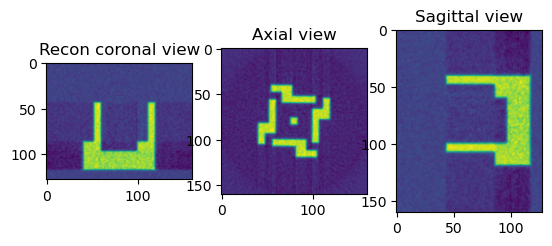

In [7]:
print ("Perform Reconstruction using FBP")

from httomolibgpu.recon.algorithm import FBP

angles = np.linspace(0.0 * np.pi / 180.0, 180.0 * np.pi / 180.0, data.shape[0])
        
reconFBP = FBP(phase_contrast_data, angles=angles, center=cor)

reconFBP_np = reconFBP.get()

sliceSel = 64
plt.figure()
plt.subplot(131)
plt.imshow(reconFBP_np[sliceSel, :, :])
plt.title("Recon coronal view")

plt.subplot(132)
plt.imshow(reconFBP_np[:, sliceSel, :])
plt.title("Axial view")

plt.subplot(133)
plt.imshow(reconFBP_np[:, :, sliceSel])
plt.title("Sagittal view")
plt.show()

Perform Reconstruction using Fourier (LPRec)


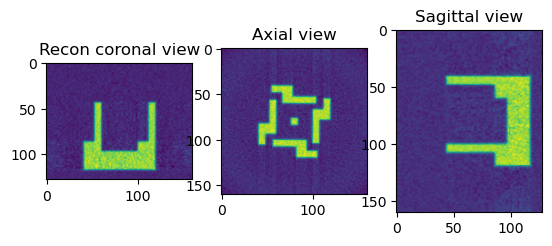

In [8]:
print ("Perform Reconstruction using Fourier (LPRec)")

from httomolibgpu.recon.algorithm import LPRec

angles = np.linspace(0.0 * np.pi / 180.0, 180.0 * np.pi / 180.0, data.shape[0])
        
reconLPRec = LPRec(phase_contrast_data, angles=angles, center=cor)

reconLPRec_np = reconLPRec.get()

sliceSel = 64
plt.figure()
plt.subplot(131)
plt.imshow(reconLPRec_np[sliceSel, :, :])
plt.title("Recon coronal view")

plt.subplot(132)
plt.imshow(reconLPRec_np[:, sliceSel, :])
plt.title("Axial view")

plt.subplot(133)
plt.imshow(reconLPRec_np[:, :, sliceSel])
plt.title("Sagittal view")
plt.show()